<a href="https://colab.research.google.com/github/barywhyte/analytics/blob/master/Mortgage%20Approval%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Mortgage Approvals From Government Data

## Part 1 - PROBLEM DEFINITION

### The main goal of the this project is to predict whether a mortgage application was approved or denied according to the given dataset.

### We're trying to predict the variable accepted (a binary variable) for each row of the test data set

In [0]:
#import libraries
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

__author__ = "Seun Ore"
__email__ = "seunsamore@gmail.com"

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn   #ignore warnings from sklearn and seaborn

## Part 2 - DISCOVER

## -----Load and Read Dataset------

In [0]:
train_url = 'https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/14/public/train_values.csv'
test_url = 'https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/14/public/test_values.csv'
label_url = 'https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/14/public/train_labels.csv'
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)
label_data = pd.read_csv(label_url)

In [4]:
train_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False
2,2,2,1,3,1,163.0,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False
3,3,1,1,1,1,155.0,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True
4,4,1,1,1,1,305.0,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False


In [5]:
#I found a stack overflow solution to quickly drop all the columns where at least 90% of the data is empty.
drop_thresh =train_data.shape[0]*.9
df = train_data.dropna(thresh=drop_thresh, how='all', axis='columns').copy()
df.shape

(500000, 22)

In [6]:
test_data.head()


,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,2,1,3,1,115.0,3,101,16,276,2,5,1,NaN,6329.0,59.536,69889.0,85.78,1874.0,2410.0,3791,True
1,1,1,1,1,1,252.0,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,2839,True
2,2,1,1,1,1,270.0,1,-1,-1,-1,2,1,2,119.0,NaN,NaN,NaN,NaN,NaN,NaN,4701,False
3,3,2,1,1,1,179.0,2,376,20,11,2,2,2,44.0,4795.0,29.676,57766.0,100.00,1426.0,1765.0,2153,True
4,4,2,1,1,1,36.0,2,254,48,156,3,6,3,32.0,5246.0,5.110,63332.0,100.00,1452.0,2092.0,5710,False


In [7]:
label_data.head()

,row_id,accepted
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


### Use .info() function to see data lengths and types

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
row_id                            500000 non-null int64
loan_type                         500000 non-null int64
property_type                     500000 non-null int64
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_ethnicity               500000 non-null int64
applicant_race                    500000 non-null int64
applicant_sex                     500000 non-null int64
applicant_income                  460052 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 no

                                                 Certain features have several missing values as seen above

## .......Clean the Data..........

In [9]:
#Check for duplicates

print(train_data.duplicated().sum())
print(test_data.duplicated().sum())
print(label_data.duplicated().sum())

0
0
0


In [10]:
#What should I do with this missing data?
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

applicant_income                  39948
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner-occupied_units    22565
number_of_1_to_4_family_units     22530
dtype: int64


## Merge train and label data

In [11]:
# Merge train data and label data

train_merge = pd.merge(train_data, label_data, on='row_id')
train_merge.tail(10)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
499990,499990,1,1,3,1,190.0,3,18,37,246,1,5,1,79.0,4671.0,85.037,61141.0,100.000,720.0,915.0,2118,False,0
499991,499991,1,1,1,1,151.0,1,72,41,296,3,6,3,27.0,8161.0,23.668,59031.0,86.953,2224.0,2919.0,6451,False,0
499992,499992,1,1,1,1,310.0,2,156,47,313,2,5,1,138.0,4858.0,10.196,73821.0,100.000,1511.0,1803.0,5907,False,1
499993,499993,1,1,3,1,200.0,3,199,26,45,2,5,2,127.0,9535.0,5.584,65139.0,100.000,2913.0,3289.0,3354,True,0
499994,499994,1,1,2,1,31.0,3,-1,37,156,2,5,2,147.0,3765.0,13.789,58049.0,100.000,1154.0,1955.0,5391,False,0
499995,499995,1,1,1,2,150.0,1,-1,-1,-1,2,2,1,87.0,NaN,NaN,NaN,NaN,NaN,NaN,969,True,0
499996,499996,1,1,1,1,140.0,3,74,47,98,2,5,1,216.0,3452.0,6.887,86307.0,100.000,1423.0,1944.0,5359,True,0
499997,499997,1,2,1,1,22.0,3,-1,46,131,3,3,1,35.0,2925.0,36.046,47826.0,100.000,1062.0,1762.0,2318,False,0
499998,499998,1,1,2,1,35.0,3,367,6,149,1,5,1,41.0,3442.0,98.879,60327.0,62.803,618.0,1297.0,5339,False,0
499999,499999,1,1,3,1,71.0,3,408,28,133,2,5,2,85.0,3856.0,12.095,45033.0,100.000,1525.0,2750.0,5710,True,0


### Imputaton technique for treating missing values
Imputation fills in the missing value with some number. The imputed value won't be exactly right in most cases, 
but it usually gives more accurate models than dropping the column entirely.

In [12]:
# make copy to avoid changing original data (when Imputing)
new_train_data = train_merge.copy()
# make new columns indicating what will be imputed
cols_with_missing = (col for col in new_train_data.columns if new_train_data[col].isnull().any())
my_imputer = Imputer()
imputed_train_data = my_imputer.fit_transform(train_merge)
imputed_train_data = pd.DataFrame(imputed_train_data)
imputed_train_data.columns = train_merge.columns
imputed_train_data.isnull().sum()



row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
accepted                          0
dtype: int64

In [14]:
#Read first 5 data samples from the new imputed train data

imputed_train_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0.0,3.0,1.0,1.0,1.0,70.0,3.0,18.0,37.0,246.0,2.0,5.0,1.0,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536.0,0.0,1.0
1,1.0,1.0,1.0,3.0,1.0,178.0,3.0,369.0,52.0,299.0,1.0,5.0,1.0,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458.0,0.0,0.0
2,2.0,2.0,1.0,3.0,1.0,163.0,3.0,16.0,10.0,306.0,2.0,5.0,1.0,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710.0,0.0,1.0
3,3.0,1.0,1.0,1.0,1.0,155.0,1.0,305.0,47.0,180.0,2.0,5.0,1.0,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888.0,1.0,1.0
4,4.0,1.0,1.0,1.0,1.0,305.0,3.0,24.0,37.0,20.0,2.0,3.0,2.0,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289.0,0.0,1.0


### Imputaton technique must also be done for test data too

In [15]:
# make copy to avoid changing original data (when Imputing)
new_test_data = test_data.copy()
# make new columns indicating what will be imputed
cols_with_missing_test = (col for col in new_test_data.columns if new_test_data[col].isnull().any())
my_imputer = Imputer()
imputed_test_data = my_imputer.fit_transform(test_data)
imputed_test_data = pd.DataFrame(imputed_test_data)
imputed_test_data.columns = test_data.columns
imputed_test_data.isnull().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
dtype: int64

### Some missing values are also indicated by -1 in certain column
There are 76,982 sample data with missing **msa_md**, 
19132 sample data with missing **state_code** and 
20466 sample data with missing **county_code** 

In [16]:
#Lets find them 

cols_with_1 = ['msa_md', 'state_code', 'county_code']
msa_md_data = imputed_train_data[imputed_train_data['msa_md'] == -1]
state_code_data = imputed_train_data[imputed_train_data['state_code'] == -1]
county_code_data = imputed_train_data[imputed_train_data['county_code'] == -1]
print(len(msa_md_data), 'data missing in msa_md column')
print(len(state_code_data), 'data missing in state_code column')
print(len(msa_md_data), 'data missing in county_code column')

76982 data missing in msa_md column
19132 data missing in state_code column
76982 data missing in county_code column


### Before I decide what I do with those missing values, let me see if they are relevant to my target label.


There are 3 ways to do this: 
1. Correlation Matrix with Heatmap
2. Univariate Selection
3. Feature Importance

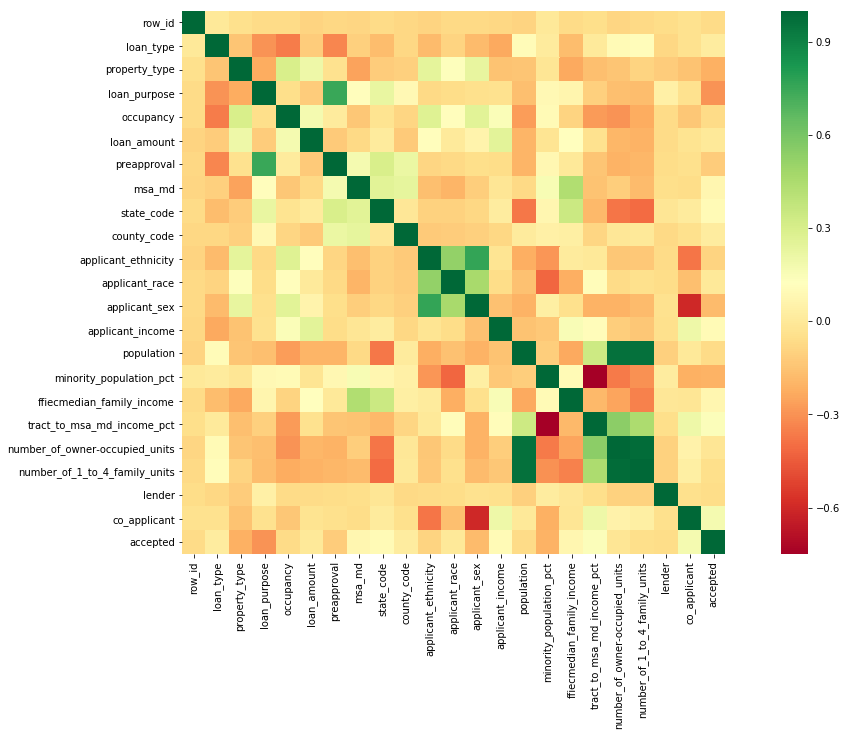

In [17]:
#Plot heatmap to see correlation

imputed_train_corr = imputed_train_data.corr()
f, ax = plt.subplots(figsize=(20,10))
top_corr_features = imputed_train_corr.index
sns.heatmap(imputed_train_corr[top_corr_features].corr(), cmap="RdYlGn", square=True);


                          A handful of these features have medium level correlation with the target label

In [0]:
#Only run target label correlation against ['msa_md', 'state_code', 'county_code']

corr = imputed_train_data[imputed_train_data.columns[1:]].corr()['accepted']
corr.sort_values(ascending=False)


accepted                          1.000000
co_applicant                      0.101116
state_code                        0.090534
tract_to_msa_md_income_pct        0.089590
msa_md                            0.080288
applicant_income                  0.071674
ffiecmedian_family_income         0.065338
county_code                       0.052613
loan_amount                       0.046370
applicant_race                    0.045361
number_of_owner-occupied_units    0.035173
occupancy                         0.022043
population                        0.018709
loan_type                         0.018589
preapproval                       0.017209
applicant_ethnicity               0.009777
lender                            0.008494
number_of_1_to_4_family_units     0.005884
applicant_sex                    -0.038391
property_type                    -0.080603
minority_population_pct          -0.090724
loan_purpose                     -0.131595
Name: accepted, dtype: float64

 From the above, **co_applicant, state_code, tract_to_msa_md_income_pct, msa_md, applicant_income, ffiecmedian_family_income, county_code, loan_amount, applicant_race, number_of_owner-occupied_units, occupancy, population, loan_type, preapproval** are the most correlated features with the target label.

#### So now I can see that ['msa_md', 'state_code', 'county_code'] features are important. Not dropping them.

I will use python replace function.

In [18]:
for x in cols_with_1:
  a = imputed_train_data[imputed_train_data[x] != -1]
  b = imputed_train_data[imputed_train_data[x] == -1]
print(a['msa_md'].median())
print(a['state_code'].median())
print(a['county_code'].median())

200.0
26.0
133.0


In [19]:
print(a.shape)
print(b.shape)
print(a.shape[0] + b.shape[0])

(479534, 23)
(20466, 23)
500000


In [0]:
#median imputation ofmissing values
imputed_train_data['msa_md'] = imputed_train_data['msa_md'].replace(to_replace = -1, value = 200)
imputed_train_data['state_code'] = imputed_train_data['state_code'].replace(-1, 26)
imputed_train_data['county_code'] = imputed_train_data['msa_md'].replace(['-1'], 133)


### Some missing values are also indicated by -1 in certain columns in test data
These too must be delt with

In [21]:
# First lets find them

cols_with_1 = ['msa_md', 'state_code', 'county_code']
msa_md_data_test = imputed_test_data[imputed_test_data['msa_md'] == -1]
state_code_data_test = imputed_test_data[imputed_test_data['state_code'] == -1]
county_code_data_test = imputed_test_data[imputed_test_data['county_code'] == -1]
print(len(msa_md_data_test), 'data missing in msa_md column')
print(len(state_code_data_test), 'data missing in state_code column')
print(len(msa_md_data_test), 'data missing in county_code column')

76993 data missing in msa_md column
19120 data missing in state_code column
76993 data missing in county_code column


In [22]:
for x in cols_with_1:
  c = imputed_test_data[imputed_train_data[x] != -1]
print(c['msa_md'].median())
print(c['state_code'].median())
print(c['county_code'].median())

192.0
26.0
131.0


In [0]:
imputed_test_data['msa_md'] = imputed_test_data['msa_md'].replace(to_replace = -1, value = 192)
imputed_test_data['state_code'] = imputed_test_data['state_code'].replace(-1, 26)
imputed_test_data['county_code'] = imputed_test_data['msa_md'].replace(['-1'], 131)

In [24]:
imputed_test_data.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0.0,2.0,1.0,3.0,1.0,115.0,3.0,101.0,16.0,101.0,2.0,5.0,1.0,101.926536,6329.000000,59.536000,69889.000000,85.780000,1874.000000,2410.000000,3791.0,1.0
1,1.0,1.0,1.0,1.0,1.0,252.0,2.0,87.0,20.0,87.0,2.0,5.0,1.0,107.000000,2473.000000,8.050000,65313.000000,100.000000,947.000000,1214.000000,2839.0,1.0
2,2.0,1.0,1.0,1.0,1.0,270.0,1.0,192.0,26.0,192.0,2.0,1.0,2.0,119.000000,5411.205196,31.631572,69254.074141,91.813397,1426.559815,1884.863422,4701.0,0.0


### Second method to determine best features : Univariate Selection

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Y = imputed_train_data['accepted']
X = imputed_train_data.drop(['accepted'], axis = 1)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 15 best features


                          Features         Score
16       ffiecmedian_family_income  6.458668e+06
5                      loan_amount  1.691292e+06
13                applicant_income  5.441040e+05
14                      population  2.296732e+05
18  number_of_owner-occupied_units  2.250502e+05
15         minority_population_pct  8.620929e+04
20                          lender  3.276927e+04
17      tract_to_msa_md_income_pct  8.428068e+03
0                           row_id  7.844683e+03
19   number_of_1_to_4_family_units  7.324747e+03


### Third method is Feature Impotance

[0.06491931 0.02312981 0.01519286 0.04072946 0.01226457 0.07017326
 0.01977513 0.05023295 0.05033877 0.04948137 0.01396725 0.02064848
 0.0208447  0.07445121 0.06619363 0.07276747 0.06921591 0.04721443
 0.06446321 0.06392075 0.07946376 0.01061171]


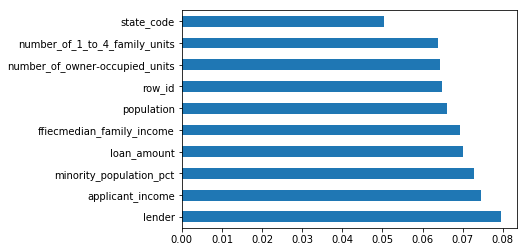

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

I am forced to not bother about the veracity of the last two methods of feature selection. Why would row_id be counted as having strong correlation with the target label. Perhaps Chi-Square test of Indenpendence would unravel that

### At this point, I am done with data cleaning. I didnt delete a column. Just imputation and replacement

Time to visualize

In [27]:
imputed_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 23 columns):
row_id                            500000 non-null float64
loan_type                         500000 non-null float64
property_type                     500000 non-null float64
loan_purpose                      500000 non-null float64
occupancy                         500000 non-null float64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null float64
msa_md                            500000 non-null float64
state_code                        500000 non-null float64
county_code                       500000 non-null float64
applicant_ethnicity               500000 non-null float64
applicant_race                    500000 non-null float64
applicant_sex                     500000 non-null float64
applicant_income                  500000 non-null float64
population                        500000 non-null float64
minority_population

In [28]:
#Examine Loan amount feature

imputed_train_data['loan_amount'].describe()


count    500000.000000
mean        221.753158
std         590.641648
min           1.000000
25%          93.000000
50%         162.000000
75%         266.000000
max      100878.000000
Name: loan_amount, dtype: float64

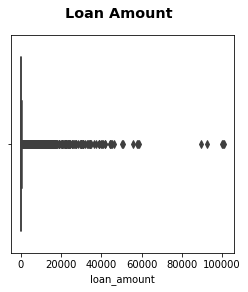

In [59]:
# Visualize Loan Amount feature
fig = plt.figure(figsize=(4,4))
fig.suptitle('Loan Amount', fontsize='x-large', fontweight='bold')

sns.boxplot(train_data.loan_amount);

                         Obviously there are upper limit outliers. 

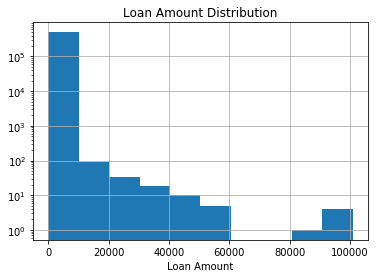

In [29]:
#check distribution of loan amount


plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
imputed_train_data['loan_amount'].hist(bins=10)
plt.yscale('log');



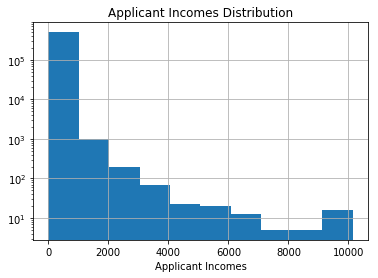

In [30]:
#check distribution of applicant income


plt.title('Applicant Incomes Distribution')
plt.xlabel('Applicant Incomes')
imputed_train_data['applicant_income'].hist(bins=10)
plt.yscale('log');

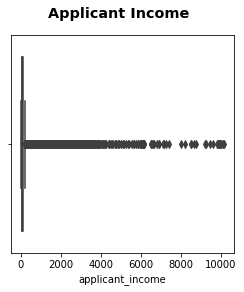

In [60]:
fig = plt.figure(figsize=(4,4))
fig.suptitle('Applicant Income', fontsize='x-large', fontweight='bold')

sns.boxplot(train_data.applicant_income);

There are outliers in Applicant Income distribution.

### Loan acceptance rates across ethnicity and gender

1 -- Hispanic or Latino
2 -- Not Hispanic or Latino
3 -- Information not provided by applicant
4 -- Not applicable
5 -- No co-applicant



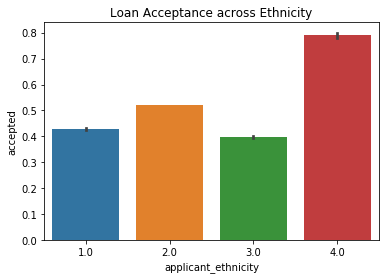

In [31]:
#Loan acceptance rates across ethnicity 
print( '''1 -- Hispanic or Latino
2 -- Not Hispanic or Latino
3 -- Information not provided by applicant
4 -- Not applicable
5 -- No co-applicant''')
print()
#plt.figure(figsize=(7,7))
plt.title('Loan Acceptance across Ethnicity')
sns.barplot(x='applicant_ethnicity', y='accepted', data=imputed_train_data);

              This only means that ethnicity is not a strong determinant for loan approval.

1 -- Male
2 -- Female
3 -- Information not provided by applicant
4 or 5 -- Not applicable



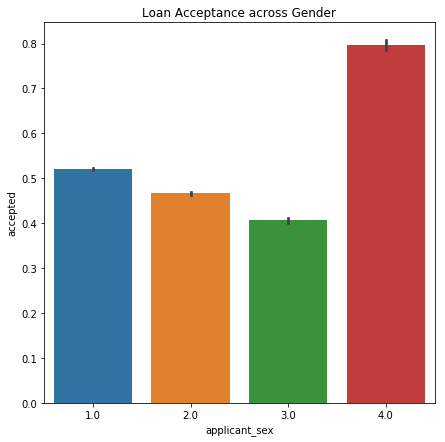

In [0]:
#Loan acceptance rates across gender 
print('''1 -- Male
2 -- Female
3 -- Information not provided by applicant
4 or 5 -- Not applicable''')
print()
plt.figure(figsize=(7,7))
plt.title('Loan Acceptance across Gender')
sns.barplot(x='applicant_sex', y='accepted', data=imputed_train_data);

This chat indicate that gender is not a strong determinant for loan approval. Male folks have higher loan approval than Female counterparts

1 -- American Indian or Alaska Native
2 -- Asian
3 -- Black or African American
4 -- Native Hawaiian or Other Pacific Islander
5 -- White
6 -- Information not provided by applicant.
7 -- Not applicable
8 -- No co-applicant



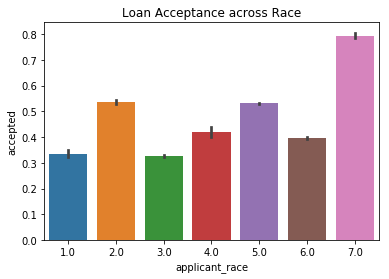

In [32]:
#Loan acceptance rates across race 
print('''1 -- American Indian or Alaska Native
2 -- Asian
3 -- Black or African American
4 -- Native Hawaiian or Other Pacific Islander
5 -- White
6 -- Information not provided by applicant.
7 -- Not applicable
8 -- No co-applicant''')
print()
#plt.figure(figsize=(7,7))
plt.title('Loan Acceptance across Race')
sns.barplot(x='applicant_race', y='accepted', data=imputed_train_data);

                Black and and African American have lowest loan approval

## Applicant income and loan amount

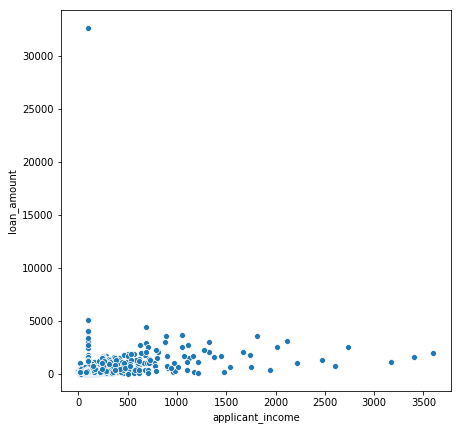

In [33]:
#Applicant Income and Loan Amount in county 45
state_45_df = imputed_train_data[imputed_train_data['state_code'] == 45]
#print(state_45_df)
plt.figure(figsize=(7,7))
sns.scatterplot(x='applicant_income', y='loan_amount', data=state_45_df);

A higher applicant income is associated with a higher loan amount, on average. There are few outliers though

### Loan acceptance across counties

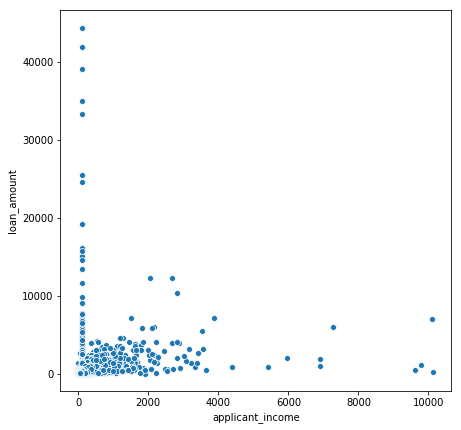

In [34]:
#Loan Acceptance in state 48 
state_48_df = imputed_train_data[imputed_train_data['state_code'] == 48]
#print(state_48_df)
plt.figure(figsize=(7,7))
sns.scatterplot(x='applicant_income', y='loan_amount', data=state_48_df);

There sems to be alot of applicants from state 48 with low income but with access to higher loans. Strange since on average higher income means loan approval. Why?

In [41]:
#Loan Acceptance in state 48 and counties (ignoring missing counties)
no_missing_county = imputed_train_data[imputed_train_data['county_code'] != -1]
#no_missing_county_48 = no_missing_county[no_missing_county['state_code'] = 48]
no_missing_county_48 = no_missing_county[no_missing_county['state_code'] == 48]
plt.figure(figsize=(7,7))
no_missing_county_48['accepted'].value_counts()

0.0    8096
1.0    7665
Name: accepted, dtype: int64

<Figure size 504x504 with 0 Axes>

15


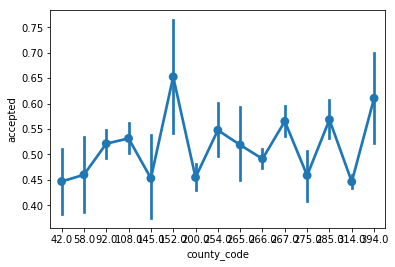

In [42]:
sns.pointplot(x = 'county_code', y = 'accepted', data=no_missing_county_48)
print(len(no_missing_county_48['county_code'].unique()))

In state 48, the average rate of loan acceptance across counties varies substantially, ranging from around 30% to arround 70%.

### Loan types across states

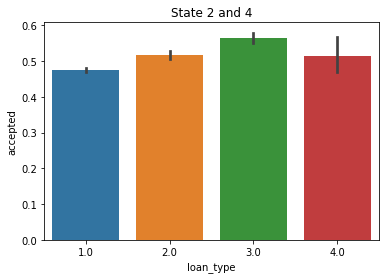

In [0]:
#Just looking at states 2 and 4
state_2 = imputed_train_data[imputed_train_data['state_code'] == 2 ]
state_4 = imputed_train_data[imputed_train_data['state_code'] == 4 ]
state_2_and_4 = pd.concat([state_2, state_4])
plt.title('State 2 and 4')
sns.barplot(x='loan_type', y='accepted', data=state_2_and_4);


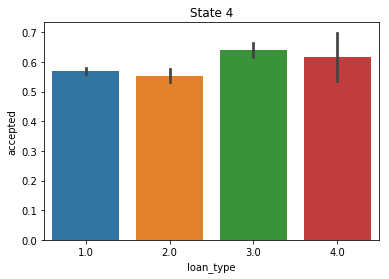

In [0]:
plt.title('State 4')
sns.barplot(x='loan_type', y='accepted', data=state_4);

For each of the four loan types, the loan acceptance rate in state 2 is lower than for the corrsponding loan type in state 4.

### Finding suspected outliers in **loan_amount** and **applicant_income** 

In [43]:
stat = imputed_train_data.loan_amount.describe()
print(stat)
iqr = stat['75%'] - stat['25%']
factor = iqr * 1.5
upper_bound = stat['75%'] + factor
lower_bound = stat['25%'] - factor
print('The upper and lower bounds for suspected outliers are', upper_bound, 'and', lower_bound)

count    500000.000000
mean        221.753158
std         590.641648
min           1.000000
25%          93.000000
50%         162.000000
75%         266.000000
max      100878.000000
Name: loan_amount, dtype: float64
The upper and lower bounds for suspected outliers are 525.5 and -166.5


In [44]:
#what class of people got such very high loan amount?
imputed_train_data.loc[imputed_train_data['loan_amount'] > 525.5, 'accepted'].value_counts()

1.0    15183
0.0    11129
Name: accepted, dtype: int64

In [0]:
stat = imputed_train_data.applicant_income.describe()
print(stat)
iqr = stat['75%'] - stat['25%']
factor = iqr * 1.5
upper_bound = stat['75%'] + factor
lower_bound = stat['25%'] - factor
print('The upper and lower bounds for suspected outliers are', upper_bound, 'and', lower_bound)

count    500000.000000
mean        102.389521
std         147.273425
min           1.000000
25%          49.000000
50%          79.000000
75%         112.000000
max       10139.000000
Name: applicant_income, dtype: float64
The upper and lower bounds for suspected outliers are 206.5 and -45.5


In [0]:
#what class of people got such very high loan amount?
imputed_train_data.loc[imputed_train_data['applicant_income'] > 206.5, 'accepted'].value_counts()

1.0    21489
0.0    13652
Name: accepted, dtype: int64

In [0]:
#what class of people got such very high loan amount?
imputed_train_data.loc[imputed_train_data['applicant_income'] < 206.5, 'accepted'].value_counts()

0.0    236234
1.0    228625
Name: accepted, dtype: int64

### Feature selection with Embedded method

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

y = imputed_train_data['accepted']
X = imputed_train_data.drop(['accepted'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.30)

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print()
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.472848
Best score using built-in LassoCV: 0.017855

Lasso picked 9 variables and eliminated the other 13 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

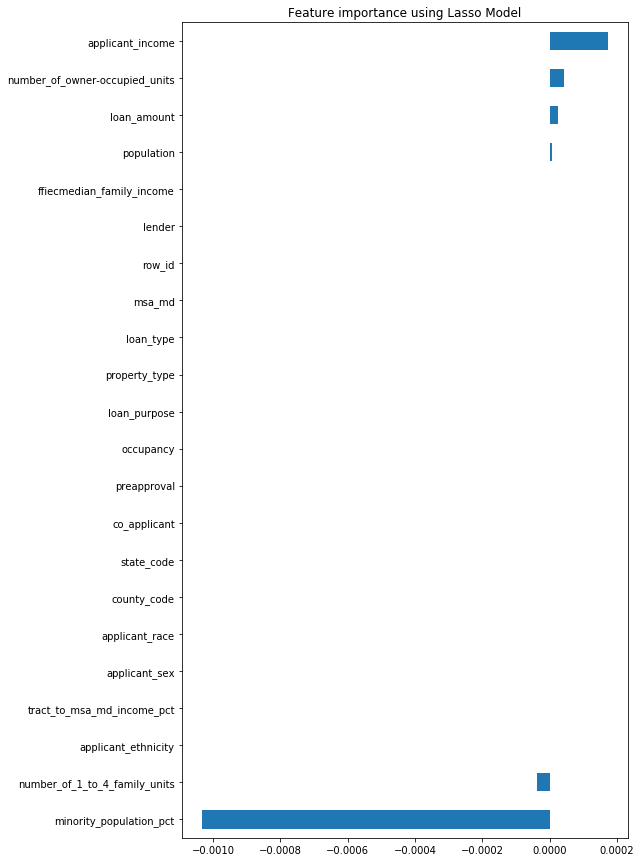

In [0]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 15.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

The following features are Lasso-picked for modelling:
msa_md, applicant_income, number_of_owner_occupied_units, loan_amount, population, gender

### Now to model based on Lasso features

In [0]:
lasso_train_feat = ['msa_md', 'applicant_income', 'number_of_owner-occupied_units', 'loan_amount', 'lender', 'property_type', 
                    'ffiecmedian_family_income','minority_population_pct', 'number_of_1_to_4_family_units', 'co_applicant', 'loan_purpose', 'accepted' ]
lasso_train_data = imputed_train_data[lasso_train_feat]

### Now to the Model Creation with lasso features


In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = lasso_train_data['accepted']
X = lasso_train_data.drop(['accepted'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.30)

my_model = XGBClassifier(n_estimators=1000, learning_rate=0.5)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
predictions = my_model.predict(test_X)

accuracy = accuracy_score(predictions, test_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.99%


In [0]:
imputed_train_data.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0.0,3.0,1.0,1.0,1.0,70.0,3.0,18.0,37.0,18.0,2.0,5.0,1.0,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536.0,0.0,1.0
1,1.0,1.0,1.0,3.0,1.0,178.0,3.0,369.0,52.0,369.0,1.0,5.0,1.0,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458.0,0.0,0.0
2,2.0,2.0,1.0,3.0,1.0,163.0,3.0,16.0,10.0,16.0,2.0,5.0,1.0,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710.0,0.0,1.0


In [0]:
imputed_test_data.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0.0,2.0,1.0,3.0,1.0,115.0,3.0,101.0,16.0,101.0,2.0,5.0,1.0,101.926536,6329.000000,59.536000,69889.000000,85.780000,1874.000000,2410.000000,3791.0,1.0
1,1.0,1.0,1.0,1.0,1.0,252.0,2.0,87.0,20.0,87.0,2.0,5.0,1.0,107.000000,2473.000000,8.050000,65313.000000,100.000000,947.000000,1214.000000,2839.0,1.0
2,2.0,1.0,1.0,1.0,1.0,270.0,1.0,192.0,26.0,192.0,2.0,1.0,2.0,119.000000,5411.205196,31.631572,69254.074141,91.813397,1426.559815,1884.863422,4701.0,0.0


##  FEATURE ENGINEERING.

## Normalizaton of Numeric data

In [61]:
list(imputed_train_data.columns)

['row_id',
 'loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'loan_amount',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'applicant_income',
 'population',
 'minority_population_pct',
 'ffiecmedian_family_income',
 'tract_to_msa_md_income_pct',
 'number_of_owner-occupied_units',
 'number_of_1_to_4_family_units',
 'lender',
 'co_applicant',
 'accepted']

In [0]:
num_cols = ['loan_amount', 'applicant_income', 'population', 'minority_population_pct', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
            'number_of_owner-occupied_units', 'number_of_1_to_4_family_units']
cat_cols = ['msa_md', 'state_code',	'county_code','lender', 'loan_type', 'property_type',	'loan_purpose',	'occupancy',
            'preapproval', 'applicant_ethnicity','applicant_race',	'applicant_sex', 'number_of_owner-occupied_units', 'applicant_race']

In [0]:
y = imputed_train_data['accepted']
x = imputed_train_data.drop(['row_id', 'accepted'], axis = 1)

In [65]:
x.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,3.0,1.0,1.0,1.0,70.0,3.0,18.0,37.0,18.0,2.0,5.0,1.0,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536.0,0.0
1,1.0,1.0,3.0,1.0,178.0,3.0,369.0,52.0,369.0,1.0,5.0,1.0,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458.0,0.0
2,2.0,1.0,3.0,1.0,163.0,3.0,16.0,10.0,16.0,2.0,5.0,1.0,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710.0,0.0
3,1.0,1.0,1.0,1.0,155.0,1.0,305.0,47.0,305.0,2.0,5.0,1.0,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888.0,1.0
4,1.0,1.0,1.0,1.0,305.0,3.0,24.0,37.0,24.0,2.0,3.0,2.0,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289.0,0.0


In [0]:
#Split data into training and test
x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.8, random_state =  22)

In [67]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400000, 21)
(100000, 21)
(400000,)
(100000,)


In [68]:
for x in num_cols:
  print('Max value :', imputed_train_data[x].max(), ',', 'Min value :', imputed_train_data[x].min(), 'for', x)
  
  

Max value : 100878.0 , Min value : 1.0 for loan_amount
Max value : 10139.0 , Min value : 1.0 for applicant_income
Max value : 37097.0 , Min value : 14.0 for population
Max value : 100.0 , Min value : 0.534 for minority_population_pct
Max value : 125248.0 , Min value : 17858.0 for ffiecmedian_family_income
Max value : 100.0 , Min value : 3.9810000000000003 for tract_to_msa_md_income_pct
Max value : 8771.0 , Min value : 4.0 for number_of_owner-occupied_units
Max value : 13623.0 , Min value : 1.0 for number_of_1_to_4_family_units


In [0]:
#Select numerical columns which needs to be normalized
train_norm = x_train[num_cols]
test_norm = x_test[num_cols]

In [0]:
# Normalize Training Data
std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)

In [71]:
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train.update(training_norm_col)
x_train.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
10397,1.0,1.0,3.0,1.0,-0.061115,3.0,276.0,45.0,276.0,2.0,5.0,1.0,-0.105558,-1.208794,-0.808665,1.422618,-0.570272,-0.912033,-1.164044,3354.0,0.0
392793,1.0,1.0,3.0,1.0,-0.143907,3.0,225.0,35.0,225.0,2.0,5.0,1.0,-0.417790,0.505204,-0.379157,0.216995,0.588367,0.716278,0.202229,2458.0,0.0
443946,2.0,1.0,1.0,1.0,-0.097544,3.0,333.0,6.0,333.0,2.0,5.0,1.0,-0.029235,2.566212,1.422341,0.057926,0.588367,2.249952,1.963676,5154.0,1.0
163775,1.0,1.0,3.0,1.0,-0.117414,3.0,101.0,16.0,101.0,2.0,3.0,1.0,-0.036173,-0.394090,0.745773,0.129483,0.588367,-0.022725,-0.251324,2458.0,0.0
63787,1.0,1.0,3.0,1.0,-0.244913,3.0,287.0,5.0,287.0,2.0,5.0,1.0,-0.466359,0.257823,-0.532175,0.264584,-0.076803,0.603548,0.824180,2816.0,0.0


In [72]:
# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test.update(testing_norm_col)
x_test.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
242689,1.0,1.0,1.0,1.0,0.011741,2.0,15.0,44.0,15.0,2.0,5.0,1.0,-0.244328,0.067211,-0.748795,-0.914585,0.588367,-0.412406,-0.335524,2118.0,1.0
101230,3.0,1.0,3.0,1.0,0.309792,3.0,345.0,28.0,345.0,1.0,5.0,1.0,-0.265143,3.327905,-0.629833,-0.908852,0.588367,3.744657,4.049572,4671.0,1.0
358956,1.0,1.0,3.0,1.0,-0.143907,3.0,267.0,48.0,267.0,2.0,5.0,2.0,-0.369220,-0.704633,-0.922651,-0.012802,0.588367,-0.804871,-0.736312,3354.0,0.0
320182,3.0,1.0,3.0,1.0,-0.216764,3.0,112.0,22.0,112.0,3.0,6.0,3.0,0.001222,0.886802,0.184124,-0.972881,-1.097346,0.852666,0.972371,6168.0,0.0
66847,1.0,1.0,1.0,1.0,-0.152187,1.0,207.0,41.0,207.0,2.0,5.0,1.0,-0.438605,-0.968932,1.721379,0.800294,-5.120239,-1.542482,-1.333565,4701.0,0.0


## Training the Model

### XGBoost Classifier

In [73]:
#Build Model with XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
norm_model = XGBClassifier(n_estimators=1000, learning_rate=1, seed = 22)
# Add silent=True to avoid printing out updates with each cycle
norm_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=22, silent=None,
              subsample=1, verbosity=1)

In [74]:
# make predictions
norm_predictions = norm_model.predict(x_test)

accuracy = accuracy_score(norm_predictions, y_test)
print("XGBoost Accuracy: %.2f%%" % (accuracy * 100.0))

XGBoost Accuracy: 70.96%


### CatBoost Classifier

In [75]:
!pip install catboost

     |████████████████████████████████| 61.1MB 578kB/s 


In [76]:
#Build Model with CatBoost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

cat_norm_model = CatBoostClassifier( random_seed = 22)
# Add silent=True to avoid printing out updates with each cycle
cat_norm_model.fit(x_train, y_train, verbose=False)

In [77]:
# make predictions
cat_norm_predictions = cat_norm_model.predict(x_test)

accuracy = accuracy_score(cat_norm_predictions, y_test)
print("CatBoost Classifier Accuracy: %.2f%%" % (accuracy * 100.0))

CatBoost Classifier Accuracy: 71.52%


## Preparing and testing with external data

In [0]:
imputed_test_data1 = imputed_test_data.drop(['row_id'], axis=1)

In [79]:
# Normalize Testing Data by using mean and SD of training set
imputed_test_norm = imputed_test_data[num_cols]

x_imputed_test_norm = std_scale.transform(imputed_test_norm)
imputed_testing_norm_col = pd.DataFrame(x_imputed_test_norm, index=imputed_test_norm.index, columns=imputed_test_norm.columns) 
imputed_test_data1.update(imputed_testing_norm_col)
imputed_test_data1.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,2.0,1.0,3.0,1.0,-0.177024,3.0,101.0,16.0,101.0,2.0,5.0,1.0,-0.001991,0.343541,1.085826,0.044526,-0.437080,0.621641,0.588423,3791.0,1.0
1,1.0,1.0,1.0,1.0,0.049826,2.0,87.0,20.0,87.0,2.0,5.0,1.0,0.033211,-1.106157,-0.915770,-0.271540,0.588367,-0.668482,-0.754274,2839.0,1.0
2,1.0,1.0,1.0,1.0,0.079631,1.0,192.0,26.0,192.0,2.0,1.0,2.0,0.116473,-0.001512,0.000999,0.000672,-0.001993,-0.001070,-0.001125,4701.0,0.0
3,2.0,1.0,1.0,1.0,-0.071050,2.0,376.0,20.0,376.0,2.0,2.0,2.0,-0.403913,-0.233180,-0.075026,-0.792814,0.588367,-0.001849,-0.135691,2153.0,1.0
4,2.0,1.0,1.0,1.0,-0.307835,2.0,254.0,48.0,254.0,3.0,6.0,3.0,-0.487174,-0.063622,-1.030067,-0.408368,0.588367,0.034336,0.231418,5710.0,0.0


In [85]:
cat_norm_pred = cat_norm_model.predict(imputed_test_data1)

cat_norm_pred_df = pd.DataFrame(cat_norm_pred, columns = ['predictions'])
cat_norm_pred_df 

,predictions
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0
5,1.0
6,0.0
7,0.0
8,1.0
9,1.0


In [0]:
from google.colab import files
cat_norm_pred_df.to_csv('pred.csv')
files.download('pred.csv')

##Below is a Python class for Chi-Square test of Independence of all features against the target label.

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

df = imputed_train_data
df['dummyCat'] = np.random.choice([0, 1], size=(len(df),), p=[0.5, 0.5])

#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
cat_cols = df.columns
for var in cat_cols:
    cT.TestIndependence(colX=var,colY="accepted" )  

row_id is NOT an important predictor. (Discard row_id from model)
loan_type is IMPORTANT for Prediction
property_type is IMPORTANT for Prediction
loan_purpose is IMPORTANT for Prediction
occupancy is IMPORTANT for Prediction
loan_amount is IMPORTANT for Prediction
preapproval is IMPORTANT for Prediction
msa_md is IMPORTANT for Prediction
state_code is IMPORTANT for Prediction
county_code is IMPORTANT for Prediction
applicant_ethnicity is IMPORTANT for Prediction
applicant_race is IMPORTANT for Prediction
applicant_sex is IMPORTANT for Prediction
applicant_income is IMPORTANT for Prediction
population is IMPORTANT for Prediction
minority_population_pct is IMPORTANT for Prediction
ffiecmedian_family_income is IMPORTANT for Prediction
tract_to_msa_md_income_pct is IMPORTANT for Prediction
number_of_owner-occupied_units is IMPORTANT for Prediction
number_of_1_to_4_family_units is IMPORTANT for Prediction
lender is IMPORTANT for Prediction
co_applicant is IMPORTANT for Prediction
accepted i

           row_id is not selected as important feature which is very much expected.